### Notebook to plot TXLA model motivational figure. 
This is to examine numerical mixing and related front quantities at various depth integrals 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 13})
import matplotlib.dates as mdates
import matplotlib.ticker as tick

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

# from dask.distributed import Client
# client = Client()

In [2]:
#Parent grid - not associated with the child grid. 
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_parent_0000*.nc')
dsp = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
dsp, gridp = xroms.roms_dataset(dsp, Vtransform = 2)

#Nested child grid
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_00*.nc')
dsc = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
dsc, gridc = xroms.roms_dataset(dsc, Vtransform = 2)

In [4]:
#Functions for plotting 
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency.
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    f_psi = xroms.to_psi(ds.f, grid)

    rvort_psi = (dvdx-dudy)/f_psi
    
    return rvort_psi 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points
    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_psi(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_psi(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

def calc_mld(sig0, xgrid, h, mask, z=None, thresh=0.03):
    """Calculate the mixed layer depth [m], return positive and as depth if no value calculated.

    Parameters
    ----------
    sig0: DataArray
        Potential density [kg/m^3]
    xgrid
        xgcm grid
    h: DataArray, ndarray
        Depths [m].
    mask: DataArray, ndarray
        mask to match sig0
    z: DataArray, ndarray, optional
        The vertical depths associated with sig0. Should be on 'rho'
        grid horizontally and vertically. Use z coords associated with DataArray sig0
        if not input.
    thresh: float, optional
        For detection of mixed layer [kg/m^3]

    Returns
    -------
    DataArray of mixed layer depth on rho horizontal grid.
    Output is `[T,Y,X]`.

    Notes
    -----
    Mixed layer depth is based on the fixed Potential Density (PD) threshold.

    Converted to xroms by K. Thyng Aug 2020 from:

    Update history:
    v1.0 DL 2020Jun07

    References:
    ncl mixed_layer_depth function at https://github.com/NCAR/ncl/blob/ed6016bf579f8c8e8f77341503daef3c532f1069/ni/src/lib/nfpfort/ocean.f
    de Boyer Montégut, C., Madec, G., Fischer, A. S., Lazar, A., & Iudicone, D. (2004). Mixed layer depth over the global ocean: An examination of profile data and a profile‐based climatology. Journal of  Geophysical Research: Oceans, 109(C12).

    Useful resources:

    * Climate Data Toolbox documentation: https://www.chadagreene.com/CDT/mld_documentation.html
    * MLD calculation from MDTF: https://github.com/NOAA-GFDL/MDTF-diagnostics/blob/437d30590c45e8b7dd0cd01a3dc67066a2137115/diagnostics/mixed_layer_depth/mixed_layer_depth.py#L147


    Examples
    --------
    >>> xroms.mld(sig0, h, mask)
    """

    if h.mean() > 0:  # if depths are positive, change to negative
        h = -h

    # xisoslice will operate over the relevant s dimension
    skey = sig0.dims[[dim[:2] == "s_" for dim in sig0.dims].index(True)]

    if z is None:
        z = sig0.z_rho

    # the mixed layer depth is the isosurface of depth where the potential density equals the surface - a threshold
    mld = xroms.isoslice(
        z,
        np.array([0.0]),
        xgrid,
        iso_array=sig0 - sig0.isel(s_rho=-1) - thresh,
        axis="Z",
    )
    #     mld = xroms.xisoslice(sig0 - sig0.isel(s_rho=-1) - thresh, 0.0, z, skey)

    # Replace nan's that are not masked with the depth of the water column.
    cond = (mld.isnull()) & (mask == 1)
    mld = mld.where(~cond, h)

    # Take absolute value so as to return positive MLD values
    mld = abs(mld)

    mld.attrs["name"] = "mld"
    mld.attrs["long_name"] = "mixed layer depth"
    mld.attrs["units"] = "m"
    mld.name = mld.attrs["name"]

    return mld.squeeze()

In [5]:
#Run functions and load data at specified time 
model_time = datetime(2010,7,4,4,30)

lon = np.array([-95,-91])
lat = np.array([27,30.3])
boxc = ((lon[0] < dsc.lon_psi) & (dsc.lon_psi < lon[1]) & (lat[0] < dsc.lat_psi) & (dsc.lat_psi < lat[1])).compute()
boxp = ((lon[0] < dsp.lon_psi) & (dsp.lon_psi < lon[1]) & (lat[0] < dsp.lat_psi) & (dsp.lat_psi < lat[1])).compute()

xislice = slice(8, 677-8) #Remove boundary points
etaslice = slice(8, 602-8)

### Calculate relative vortcity, salinity gradient magnitude, and mixed layer depth for both models 

In [7]:
rv_c = surface_vorticity(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()
sgrad_c = surface_saltgradmag(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()

rv_p = surface_vorticity(dsp, gridp).where(boxp).sel(ocean_time = model_time).load()
sgrad_p = surface_saltgradmag(dsp, gridp).where(boxp).sel(ocean_time = model_time).load()

In [8]:
# Parent 
hp = dsp.h
mask_rhop = dsp.mask_rho
rhop = xroms.potential_density(dsp.temp,dsp.salt,z=0)
rhop = rhop.sel(ocean_time = model_time).load()

# Child 
hc = dsc.h#.isel(eta_rho = etaslice, xi_rho = xislice)
mask_rhoc = dsc.mask_rho#.isel(eta_rho = etaslice, xi_rho = xislice)
rhoc = xroms.potential_density(dsc.temp,dsc.salt,z=0)
rhoc = rhoc.sel(ocean_time = model_time).load()#.isel(eta_rho = etaslice, xi_rho = xislice).load()

# Parent 
mldp_03_xroms = calc_mld(rhop, gridp, hp, mask_rhop, z=None, thresh=0.03)
mldp_03_xroms_psi = xroms.to_psi(mldp_03_xroms, gridp)

# Sensitivity study - change the threshold cutoff
mldp_02_xroms = calc_mld(rhop, gridp, hp, mask_rhop, z=None, thresh=0.02)
mldp_02_xroms_psi = xroms.to_psi(mldp_02_xroms, gridp)
mldp_01_xroms = calc_mld(rhop, gridp, hp, mask_rhop, z=None, thresh=0.01)
mldp_01_xroms_psi = xroms.to_psi(mldp_01_xroms, gridp)

# Child
mldc_03_xroms = calc_mld(rhoc, gridc, hc, mask_rhoc, z=None, thresh=0.03)
mldc_03_xroms_psi = xroms.to_psi(mldc_03_xroms, gridc)
# Sensitivity study
mldc_02_xroms = calc_mld(rhoc, gridc, hc, mask_rhoc, z=None, thresh=0.02)
mldc_02_xroms_psi = xroms.to_psi(mldc_02_xroms, gridc)
mldc_01_xroms = calc_mld(rhoc, gridc, hc, mask_rhoc, z=None, thresh=0.01)
mldc_01_xroms_psi = xroms.to_psi(mldc_01_xroms, gridc)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/d2/home/dylan/.conda/envs/copano/lib/py

### Now calculate the bulk mixing within the mixed layer 

In [9]:
mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(dsp.z_rho_psi.sel(ocean_time = model_time)>(-mldp_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(dsc.z_rho_psi.sel(ocean_time = model_time)>(-mldc_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(dsp.z_rho_psi.sel(ocean_time = model_time)>(-mldp_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(dsc.z_rho_psi.sel(ocean_time = model_time)>(-mldc_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.24585301579653146


### Clean things up, check calcs

In [10]:
zrhopsi_p = dsp.z_rho_psi.sel(ocean_time = model_time)
zrhopsi_c = dsc.z_rho_psi.sel(ocean_time = model_time)

mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(zrhopsi_p>(-mldp_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(zrhopsi_c>(-mldc_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(zrhopsi_p>(-mldp_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(zrhopsi_c>(-mldc_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.24585301579653146


### Now plot the motivational figure 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically i

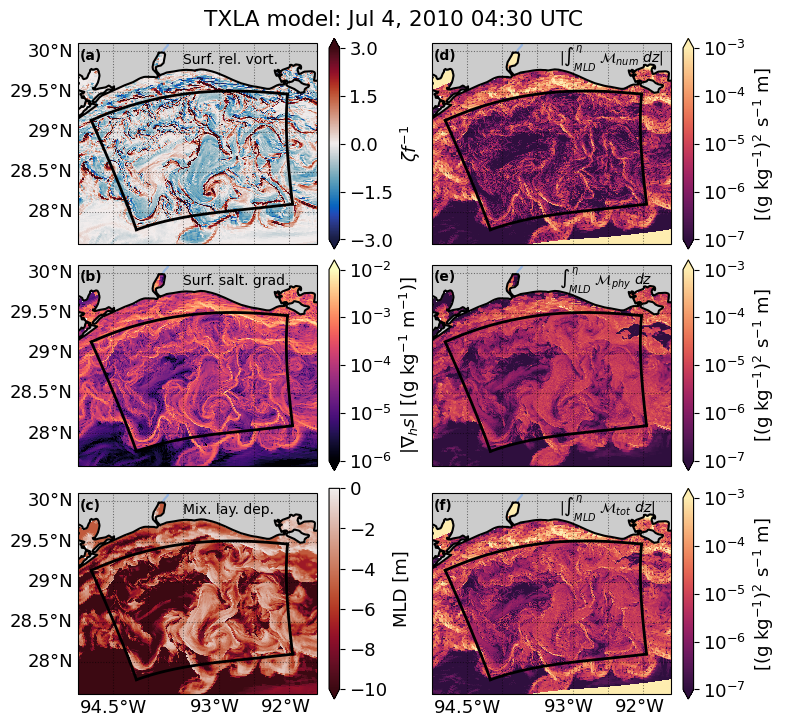

In [12]:
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(7.75,(12/5)*3), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

#Aspect ratio for plot
dss_lat = dsc.where(boxc).lat_rho
lat_rad = 1.0/np.cos(np.radians(dss_lat.mean().values))

mappable = ax[0,0].pcolormesh(dsp.lon_psi,
                              dsp.lat_psi,
                              rv_p, 
                              cmap = cmo.balance,
                              vmin = -3,
                              vmax = 3,
                              transform = ccrs.PlateCarree())

mappable = ax[0,0].pcolormesh(dsc.lon_psi,
                              dsc.lat_psi,
                              rv_c, 
                              cmap = cmo.balance,
                              vmin = -3,
                              vmax = 3,
                              transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', ticks = [-3, -1.5, 0, 1.5, 3], pad = 0.05)
cb.set_label(r'$\zeta f^{-1}$')

mappable1 = ax[1,0].pcolormesh(dsp.lon_psi,
                            dsp.lat_psi,
                            np.log10(sgrad_p), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

mappable1 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.05)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable2 = ax[2,0].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               -mldp_03_xroms_psi, 
                               cmap = cmo.amp_r,
                               vmin = -10,
                               vmax = 0,
                               transform = ccrs.PlateCarree())
mappable2 = ax[2,0].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                              -mldc_03_xroms_psi, 
                               cmap = cmo.amp_r,
                               vmin = -10,
                               vmax = 0,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'min', pad = 0.05)
cb.set_label(r'MLD [m]')

mappable3 = ax[0,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mnum_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable3 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable4 = ax[1,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mphy_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable4 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable4, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable5 = ax[2,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mtot_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable5 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surf. rel. vort.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surf. salt. grad.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate(r'$\left|\int_{MLD}^{\eta} \, \, \mathcal{M}_{num} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate(r'$\int_{MLD}^{\eta} \, \, \mathcal{M}_{phy} \, \, dz$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Mix. lay. dep.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate(r'$\left|\int_{MLD}^{\eta} \, \, \mathcal{M}_{tot} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

fig.suptitle("TXLA model: Jul 4, 2010 04:30 UTC")
fig.canvas.draw()
plt.savefig('output/figs/txla_snap_int_mld.jpg', dpi = 800, bbox_inches='tight')

### Repeat for the top 1 m and the entire water column 

In [13]:
zrhopsi_p = dsp.z_rho_psi.sel(ocean_time = model_time)
zrhopsi_c = dsc.z_rho_psi.sel(ocean_time = model_time)

mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(zrhopsi_p>(-1))).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(zrhopsi_c>(-1))).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(zrhopsi_p>(-1))).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(zrhopsi_c>(-1))).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.5263308286881289


In [14]:
zrhopsi_p = dsp.z_rho_psi.sel(ocean_time = model_time)
zrhopsi_c = dsc.z_rho_psi.sel(ocean_time = model_time)

mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = mnum_p_psi.sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = mnum_c_psi.sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = mphy_p_psi.sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = mphy_c_psi.sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.14124564725539127


### Sensitivity study - see how changing the density cutoff threshold impacts the ratio 

In [15]:
zrhopsi_p = dsp.z_rho_psi.sel(ocean_time = model_time)
zrhopsi_c = dsc.z_rho_psi.sel(ocean_time = model_time)

mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(zrhopsi_p>(-mldp_02_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(zrhopsi_c>(-mldc_02_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(zrhopsi_p>(-mldp_02_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(zrhopsi_c>(-mldc_02_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.2945388139077434


In [16]:
zrhopsi_p = dsp.z_rho_psi.sel(ocean_time = model_time)
zrhopsi_c = dsc.z_rho_psi.sel(ocean_time = model_time)

mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(zrhopsi_p>(-mldp_01_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(zrhopsi_c>(-mldc_01_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(zrhopsi_p>(-mldp_01_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(zrhopsi_c>(-mldc_01_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.37256728013711315


In [19]:
#mean
print(mldc_03_xroms.mean().values)
print(mldc_02_xroms.mean().values)
print(mldc_01_xroms.mean().values)
#Standard deviation
print(mldc_03_xroms.std().values)
print(mldc_02_xroms.std().values)
print(mldc_01_xroms.std().values)

7.21106232608346
6.938339620807459
6.574736687826385
5.019249090900501
4.8887057337445174
4.73802848208905
